In [36]:
from brian2 import *
%matplotlib inline
from time import time
from scipy.signal import find_peaks
from ipywidgets import interact_manual, FloatSlider, interact

In [49]:

#Constants
i_const = 160*pA
C = 100*pF; gL = 12*nS; EL = -60*mV; VT = -50*mV; 
DeltaT = 2*mV; tauw = 130*ms; a = -11*nS;
tau_s = 1*ms; ks= 0.3*nA; ss = 125; ds = 3; hs = -0.045; 
I0 = 1*amp; V0 = 1*volt;
Dn = 0.8; tau_n = 25*Hz; 
epsilon_c = 0.04; tau_c = 10*ms; 
C1 = 0.13; C2 = 0.9; C3 = 0.004; C4 = 2/epsilon_c
tausm = 100*ms; ssm = 100; hsm = 0.45; dsm = 3;
tauGm = 5*tausm; sgm = ssm; hgm = 0.5; dgm = 3;

z0 = 2*ds/(1+2*ds+exp(-2*ss*(-0.015)))
print('z0 = ',z0)

# presynaptic neuron A/Abis
eqs1 = '''
        I = i_const*(t > 50*ms)*(t < 1000*ms) : amp
        dv1/dt = (gL*(EL-v1)+gL*DeltaT*exp((v1-VT)/DeltaT) - w1 + I + 0*(I0-gamma)*gm)/C: volt
        dw1/dt=(a*(v1-EL)-w1)/tauw : amp
        gm : 1 (linked)
        
       '''
eqs1bis = '''
        I = i_const*(t > 50*ms)*(t < 2000*ms) : amp
        dv1/dt = (gL*(EL-v1)+gL*DeltaT*exp((v1-VT)/DeltaT) - w1 + I + 0*(I0-gamma)*gm)/C: volt
        dw1/dt=(a*(v1-EL)-w1)/tauw : amp
        gm : 1 (linked)
        
       '''
# postsynaptic neuron B
eqs2 = '''dv2/dt = (gL*(EL-v2)+gL*DeltaT*exp((v2-VT)/DeltaT) - w2 + I_syn + I_glion)/C : volt
          dw2/dt=(a*(v2-EL)-w2)/tauw : amp
          dz/dt = (1/tau_s)*((1+tanh(ss*((v_inp/V0)-hs)))*(1 - z) - z/ds) : 1
          I_syn = (ks - delta*Gm)*(z-z0) : amp
          I_glion = gamma*Gm : amp
          dGm/dt = (1/tauGm)*((1 + tanh(sgm*(c - hgm)))*(1-Gm)- Gm/dgm) : 1
          dc/dt = (1/tau_c)*(- c - C4*((C1*c*c/(1+c*c)) - (ce*ce/(1+ce*ce))*((c**4)/(C2**4 + c**4)) - C3*ce) + r + alpha*w2 + beta*Sm) : 1 
          dce/dt = (1/(tau_c*epsilon_c))*((C1*c*c/(1+c*c)) - (ce*ce/(1+ce*ce))*((c**4)/(C2**4 + c**4)) - C3*ce) : 1
          dSm/dt = (1/tausm)*((1 + tanh(ssm*(z - hsm)))*(1-Sm)-Sm/dsm) : 1
          v_inp : volt (linked)
      '''
# downstream neuron C
eqs3 = '''dv3/dt = (gL*(EL-v3)+gL*DeltaT*exp((v3-VT)/DeltaT) - w3 + I_syn)/C : volt
          dw3/dt=(a*(v3-EL)-w3)/tauw : amp
          I_syn : amp (linked)
          v_inp : volt (linked)
      '''

z0 =  0.1211605190692803


In [50]:
run_time = 10000*ms

In [51]:
#Définition de la synapse  
def synapse_plot(r,Alpha,beta,Gamma,delta,i):
    #Initialization
    defaultclock.dt = 0.01*ms
    alpha = Alpha*amp**(-1); 
    gamma = Gamma*nA;
    delta = delta*nA
    #PRE-SYNAPTIC NEURO
    neuronA = NeuronGroup(1, eqs1, threshold='v1 > -30*mV', reset='v1=-70*mV; w1 += 30*pA', method = "euler")
    neuronAbis = NeuronGroup(1, eqs1bis, threshold='v1 > -30*mV', reset='v1=-70*mV; w1 += 30*pA', method = "euler")
    #initial values
    neuronA.v1 = EL
    neuronA.w1 = 0*nA
    neuronAbis.v1 = EL
    neuronAbis.w1 = 0*nA

    
    #POST-SYNAPTIC NEURON
    neuronB = NeuronGroup(1, eqs2, threshold='v2 > -30*mV', reset='v2=-70*mV; w2 += 30*pA', method = "euler")
    neuronC = NeuronGroup(1, eqs3, threshold='v3 > -30*mV', reset='v3=-70*mV; w3 += 30*pA', method = "euler")
    #initial values
    neuronB.v2 = EL
    neuronB.w2 = 0*nA
    neuronB.z = z0
    neuronB.c = 0
    neuronB.ce = 0
    neuronB.Sm = 0
    neuronB.Gm = 0
    
    neuronC.v3 = EL
    neuronC.w3 = 0*nA
    
    #LINKED VALUES
    neuronA.gm = linked_var(neuronB, 'Gm')
    neuronAbis.gm = linked_var(neuronB, 'Gm')
    neuronB.v_inp = linked_var(neuronA, 'v1')
    neuronC.v_inp = linked_var(neuronB, 'v2')
    neuronC.I_syn = linked_var(neuronB, 'I_syn')
    
    #MONITORS
    V1 = StateMonitor(neuronA, 'v1', record=0)
    I1 = StateMonitor(neuronA, 'I', record=0)

    V1bis = StateMonitor(neuronAbis, 'v1', record=0)
    
    Z = StateMonitor(neuronB, 'z', record=0)
    Cal = StateMonitor(neuronB, 'c', record=0)
    CE = StateMonitor(neuronB, 'ce', record=0)
    SM = StateMonitor(neuronB, 'Sm', record=0)
    GM = StateMonitor(neuronB, 'Gm', record=0)
    IG = StateMonitor(neuronB, 'I_glion', record=0)
    
    V2 = StateMonitor(neuronB, 'v2', record=0)
    I2 = StateMonitor(neuronB, 'I_syn', record=0)
    
    V3 = StateMonitor(neuronC, 'v3', record=0)


    #Synapse
    syn1 = Synapses(neuronA, neuronB)
    syn1.connect(i=0, j=0)
    syn2 = Synapses(neuronAbis, neuronB)
    syn2.connect(i=0, j=0)
    syn3 = Synapses(neuronB, neuronC)
    syn3.connect(i=0, j=0)
    run(run_time)
    
    #PLOT
    plot(V1bis.t/ms, V1bis.v1[0], label='Neuron Abis')
    plot(V1.t/ms, V1.v1[0], label='Neuron A')
    plot(V2.t/ms, V2.v2[0], label='Neuron B')
    plt.axvline(x = 500, color = 'k', label = 'axvline - full height') #line to show the end of I1
    plot(V3.t/ms, V3.v3[0], label='Neuron C')
    xlabel('Time (ms)')
    ylabel('v (V)')
    legend();
    plt.savefig(str(i)+'V(t).png')
    show()
    
    plot(Cal.t/ms, Cal.c[0], label='c',color='m')
    plot(CE.t/ms, CE.ce[0], label='ce')
    plot(SM.t/ms, SM.Sm[0], label='Sm')
    plot(GM.t/ms, GM.Gm[0], label='Gm')
    xlabel('Time (ms)')
    ylabel('c (g.L-1)')
    legend();
    plt.savefig(str(i)+'C(t).png')
    show()
    
    plot(I2.t/ms, I2.I_syn[0], label='I_syn')
    plot(I1.t/ms, I1.I[0], label='I1')
    plot(IG.t/ms, IG.I_glion[0], label='Iglion')
    plot(IG.t/ms, IG.I_glion[0]+I2.I_syn[0], label='Isyn + Iglion')
    xlabel('Time (ms)')
    ylabel('Courants (A)')
    legend(); 
    plt.savefig(str(i)+'I(t).png')
    show()
    
    #SPIKES
    peaks_V1, _ = find_peaks(V1.v1[0])
    peaks_V2, _ = find_peaks(V2.v2[0])
    peaks_V3, _ = find_peaks(V3.v3[0])
    peaks_c, _ = find_peaks(Cal.c[0])
    ITC = [Cal.t[peaks_c[i]] for i in range(len(peaks_c))]
    ITV1 = [V1.t[peaks_V1[i]] for i in range(len(peaks_V1))]
    ITV2 = [V2.t[peaks_V2[i]] for i in range(len(peaks_V2))]
    ITV3 = [V3.t[peaks_V3[i]] for i in range(len(peaks_V3))]
    print('V1 : ', len(peaks_V1),'V2 : ', len(peaks_V2),'c : ', len(peaks_c))
    return ITC,len(peaks_c),ITV1,len(peaks_V1),ITV2,len(peaks_V2),ITV3,len(peaks_V3)
    

    
    


Paramètres de départ I1 = 160pa


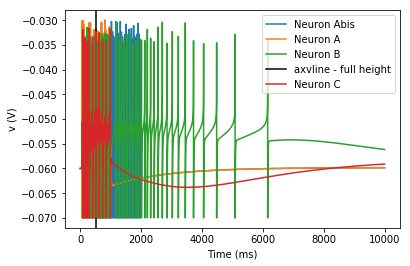

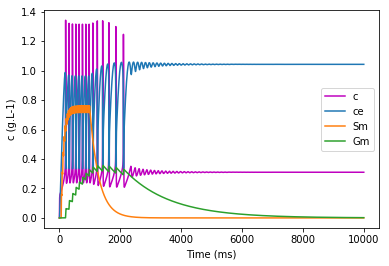

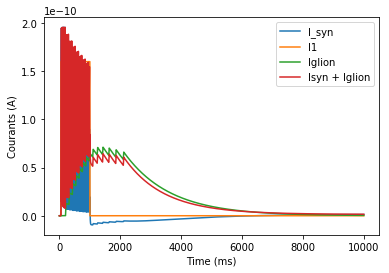

V1 :  28 V2 :  55 c :  77


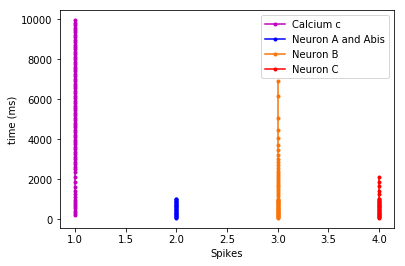

617.1967949867249


In [52]:

d = time()
print('Paramètres de départ I1 = 160pa')
ITC1,lenC1,ITV11,lenV11,ITV21,lenV21,ITV3,lenITV3 = synapse_plot(0.31,0.001,0.1,0.2,0.5,'A=AbisLong')
f = time()
plot(lenC1*[1],ITC1/ms, label = 'Calcium c', marker=".",color='m')
plot(lenV11*[2],ITV11/ms, label = 'Neuron A and Abis', marker=".",color='b')
plot(lenV21*[3],ITV21/ms, label = 'Neuron B', marker=".",color='#F97306')
plot(lenITV3*[4],ITV3/ms, label = 'Neuron C', marker=".",color='r')
ylabel('time (ms)')
xlabel('Spikes')
legend(); 
plt.savefig('I_C_Spikes.png')
show()
print(f-d)
